# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from urllib.error import HTTPError
import seaborn as sns

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

634

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
# OpenWeatherMap API Key
api_key = "19f617e49bc08fb97137c4f01a36e91d"

# Starting URL for Weather Map API Call
url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=" + api_key

city_name = []
cloudiness = []
country = []
date = []
humidity = []
lat = []
lng = []
max_temp = []
wind_speed = []

# Start the call counter 
record = 1

# Log file print statement
print(f"Beginning Data Retrieval")
print(f"-------------------------------")

#Loop through the cities in the city list 
for city in cities:  
    
    # Try statement to append calls where value is found 
    # Not all calls return data as OpenWeatherMap will not have have records in all the cities generated by CityPy module
    try: 
        response = requests.get(f"{url}&q={city}").json() 
        city_name.append(response["name"])
        cloudiness.append(response["clouds"]["all"])
        country.append(response["sys"]["country"])
        date.append(response["dt"])
        humidity.append(response["main"]["humidity"])
        max_temp.append(response["main"]["temp_max"])
        lat.append(response["coord"]["lat"])
        lng.append(response["coord"]["lon"])
        wind_speed.append(response["wind"]["speed"])
        city_record = response["name"]
        print(f"Processing Record {record} | {city_record}")
        print(f"{url}&q={city}")
        
        # Increase counter by one 
        record= record + 1
        
        # Wait a second in loop to not over exceed rate limit of API
        time.sleep(1.01)
        
    # If no record found "skip" to next call
    except:
        print("City not found. Skipping...")
    continue

Beginning Data Retrieval
-------------------------------
Processing Record 1 | Mataura
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=19f617e49bc08fb97137c4f01a36e91d&q=mataura
Processing Record 2 | Tiksi
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=19f617e49bc08fb97137c4f01a36e91d&q=tiksi
Processing Record 3 | Severo-Kuril'sk
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=19f617e49bc08fb97137c4f01a36e91d&q=severo-kurilsk
Processing Record 4 | Novyy Buh
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=19f617e49bc08fb97137c4f01a36e91d&q=novyy buh
Processing Record 5 | Smithers
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=19f617e49bc08fb97137c4f01a36e91d&q=smithers
Processing Record 6 | El Alto
http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=19f617e49bc08fb97137c4f01a36e91d&q=el alto
Processing Record 7 | Lebu
http://api.openweathermap.org/data/2.5/weather?units=

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [38]:
# Creating a dictionary with my lists, containing the data returned from OpenWeather JSON.
city_weather_dict = pd.DataFrame({
     'City':city_name,
     'Cloudiness':cloudiness,
     'Country':country,
     'Date':date,
     'Humidity':humidity,
     'Lat':lat,
     'Lng':lng,
     'Max Temperature':max_temp,
     'Wind Speed':wind_speed,
    })

# Creating a dataframe, from my dictionary
city_data = pd.DataFrame(city_weather_dict)
city_data.to_csv("sanity/city_data.csv", index="True")
city_data.head()

,City,Cloudiness,Country,Date,Humidity,Lat,Lng,Max Temperature,Wind Speed
0,Mataura,85,NZ,1589746747,91,-46.19,168.86,44.83,2.48
1,Tiksi,100,RU,1589746503,95,71.69,128.87,33.10,12.46
2,Severo-Kuril'sk,100,RU,1589746750,93,50.68,156.12,35.28,21.27
3,Novyy Buh,40,UA,1589746751,93,47.69,32.52,51.80,4.47
4,Smithers,90,CA,1589746752,82,54.78,-127.17,55.40,8.05


In [39]:
# Get the indices of cities that have humidity over 100%.
humidity_indicies = city_data[city_data['Humidity']>100].index.tolist()

if not humidity_indicies:
    print("There are no Humidity values greater than 100")
else:
    print(humidity_indicies)

There are no Humidity values greater than 100


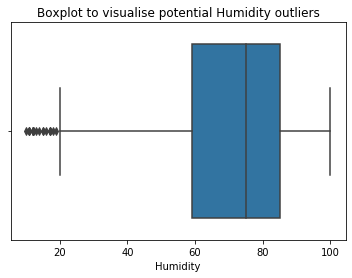

In [40]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.

# creating boxplot to visualise potential 'Humidity' outliers
fig1 = sns.boxplot(x=city_data['Humidity']).set_title("Boxplot to visualise potential Humidity outliers")

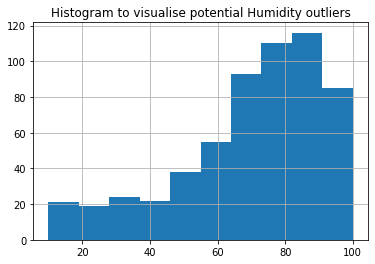

In [41]:
fig2 = city_data.Humidity.hist().set_title("Histogram to visualise potential Humidity outliers")

In [50]:
# Calculating the IQR for the Humidity column
Q1 = city_data['Humidity'].quantile(0.25)
print(f'Humidity Q1 is: {Q1}')
Q3 = city_data['Humidity'].quantile(0.75)
print(f'Humidity Q3 is: {Q3}')
IQR = Q3 - Q1
print(f'Humidity IQR: {IQR}')

# Having analysed the graphic representations of the city_data Dataframe, I removed outliers equal to or less than 45
# and equal to or greater than 100
clean_city_data = city_data[(city_data['Humidity'] >= 100)|(city_data['Humidity'] <= 45)].index
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
city_data.drop(clean_city_data, inplace=True)
# city_data['Humidity'].describe()



# Saving new dataframe as .csv to do sanity check
city_data.to_csv("sanity/post_floor_cap_city_data.csv", index="True")
# printing new dataframe shape, to demonstrate outliers for Humidity have removed entire rows impacted
print(f'New Dataframe shape: {city_data.shape}')

Humidity Q1 is: 66.0
Humidity Q3 is: 86.0
Humidity IQR: 20.0
New Dataframe shape: (486, 9)


In [ ]:
# Extract relevant fields from the data frame


# Export the City_Data into a csv


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

## Latitude vs. Humidity Plot

## Latitude vs. Cloudiness Plot

## Latitude vs. Wind Speed Plot

## Linear Regression

In [ ]:
# OPTIONAL: Create a function to create Linear Regression plots

In [ ]:
# Create Northern and Southern Hemisphere DataFrames

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression